In [55]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Local imports
from main_training import main
from custom_model import initialize_model
from dataloader import DataLoaderSegmentation
from train import iou

C:\Users\tomas\AppData\Local\Temp\ipykernel_22692\1384538113.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [3]:
data_dir = r'..\..\data\training_def'
dest_dir = r'..\..\models\deepLabV3_r3'
city_scape = r'..\..\models\deepLabV3_r2\model_13_2_2_2_epoch_580.pth'
num_classes = 7
num_epochs = 25
batch_size = 4

### Training

In [3]:
state, model, hist = main(data_dir, dest_dir, num_classes, batch_size, num_epochs)

Initializing Datasets and Dataloaders...
Initializing Model...


C:\Users\tomas\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tomas\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 module.classifier.0.convs.0.0.weight
	 module.classifier.0.convs.0.1.weight
	 module.classifier.0.convs.0.1.bias
	 module.classifier.0.convs.1.0.weight
	 module.classifier.0.convs.1.1.weight
	 module.classifier.0.convs.1.1.bias
	 module.classifier.0.convs.2.0.weight
	 module.classifier.0.convs.2.1.weight
	 module.classifier.0.convs.2.1.bias
	 module.classifier.0.convs.3.0.weight
	 module.classifier.0.convs.3.1.weight
	 module.classifier.0.convs.3.1.bias
	 module.classifier.0.convs.4.1.weight
	 module.classifier.0.convs.4.2.weight
	 module.classifier.0.convs.4.2.bias
	 module.classifier.0.project.0.weight
	 module.classifier.0.project.1.weight
	 module.classifier.0.project.1.bias
	 module.classifier.1.weight
	 module.classifier.2.weight
	 module.classifier.2.bias
	 module.classifier.4.weight
	 module.classifier.4.bias
Train...
Epoch 1/25
----------
train Loss: 1.3642 Acc: 0.1227
val Loss: 1.6755 Acc: 1.0000

Epoch 2/25
----------
train Loss: 0.4096 Acc: 0.9333
val Los

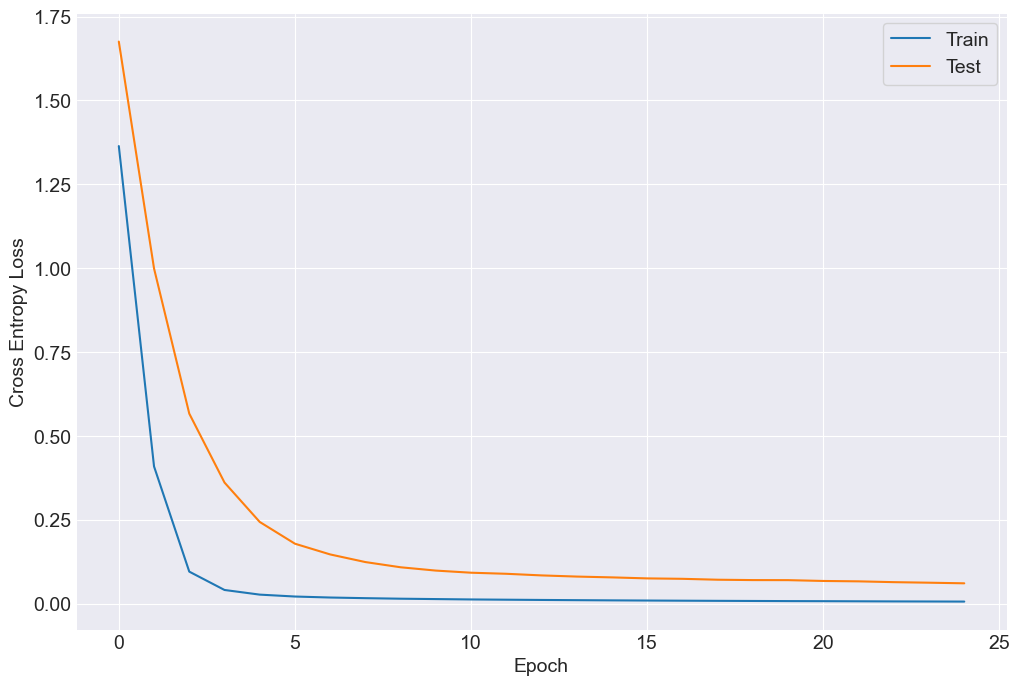

In [4]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(hist['train_loss'], label = 'Train')
ax.plot(hist['val_loss'], label = 'Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross Entropy Loss')
ax.legend(frameon = True)

### Inference

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = initialize_model(num_classes, use_pretrained = False)
state_dict = torch.load(os.path.join(dest_dir, 'best_DeepLabV3_floodDetection.pth'), 
                        map_location = device)

model = model.to(device)
model.load_state_dict(state_dict, strict=False)
model.eval()

C:\Users\tomas\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tomas\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [56]:
pathout = r'../../models/deepLabV3_r2/outputs'

path_test_images = r'../../data/training_def/test/Images'
path_test_labels = r'../../data/training_def/test/Labels'
images = [os.path.join(path_test_images, x) for x in os.listdir(path_test_images)]
labels = [os.path.join(path_test_labels, x[:-4]+'_label.jpg') for x in os.listdir(path_test_images)]

transforms_image =  transforms.Compose([transforms.ToTensor()])

for im, lab in zip(images, labels):
    print(im)
    print(lab+'\n')
    ## prediction
    image = Image.open(im)
    image_np = np.asarray(image)
    image = transforms_image(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    outputs = model(image)["out"]
    _, preds = torch.max(outputs, 1)
    preds = preds.to("cpu")
    preds_np = preds.squeeze(0).cpu().numpy().astype(np.uint8)
    preds_np_color = cv2.applyColorMap(preds_np * 50, cv2.COLORMAP_HSV)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    
    ## label
    true_label = cv2.imread(lab)
    true_label = np.clip(true_label, 0, num_classes)
    true_label_color = cv2.applyColorMap(true_label * 50, cv2.COLORMAP_HSV)
    
#     label_aux = transforms_image(Image.fromarray(true_label)).squeeze(0)
    iou_mean = jaccard_score(true_label.max(2).reshape(-1), preds_np.reshape(-1), average = 'macro')
#     iou_mean = iou(preds, label_aux.max(0)[0], num_classes).mean()
    
    ## plot
    fig, ax = plt.subplots(figsize = (20, 20), sharey = True, ncols = 2)
    ax[0].imshow(image_np)
    ax[0].imshow(true_label_color, alpha = 0.3)
    ax[1].imshow(image_np)
    ax[1].imshow(preds_np_color, alpha = 0.3)

    ax[0].set_title('True labels')
    ax[1].set_title(f'Predicted labels: Mean IoU = {iou_mean:0.2f}')
    
    fig.savefig(os.path.join(pathout, os.path.basename(im)[:-4]+'_prediction.jpg'), dpi = 200, bbox_inches = 'tight')
    plt.close()

../../data/training_def/test/Images\resized_CAM_BF_01_20220515235422_rtm.jpg
../../data/training_def/test/Labels\resized_CAM_BF_01_20220515235422_rtm_label.jpg

../../data/training_def/test/Images\resized_CAM_BF_01_20220517004222_rtm.jpg
../../data/training_def/test/Labels\resized_CAM_BF_01_20220517004222_rtm_label.jpg

../../data/training_def/test/Images\resized_CAM_BF_01_20221120192422_rtm.jpg
../../data/training_def/test/Labels\resized_CAM_BF_01_20221120192422_rtm_label.jpg

../../data/training_def/test/Images\resized_CAM_BF_01_20221109125422_rtm.jpg
../../data/training_def/test/Labels\resized_CAM_BF_01_20221109125422_rtm_label.jpg

../../data/training_def/test/Images\resized_CAM_BF_01_20221030232422_rtm.jpg
../../data/training_def/test/Labels\resized_CAM_BF_01_20221030232422_rtm_label.jpg

../../data/training_def/test/Images\resized_CAM_BF_01_20220519024221_rtm.jpg
../../data/training_def/test/Labels\resized_CAM_BF_01_20220519024221_rtm_label.jpg

../../data/training_def/test/Image

In [60]:
preds_np.shape

(749, 1000)

In [61]:
true_label

array([[[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [2, 2, 2]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]], dtype=uint8)

In [50]:
true_label.max(2).shape

(749, 1000)

In [54]:
jaccard_score(true_label.max(2).reshape(-1), preds_np.reshape(-1), average = 'macro')

0.007990375611333977